In [1]:
dom_indir = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/dominant_clone_clust/"
clone_change_f = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/preproc/clone_change.csv"
outdir= "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/gff_A2_black/annotation_clones/aggregate_clone_meta"
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
input_id = "Input"

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join, basename, exists
import click
from glob import glob
from mplh.fig_utils import helper_save as hs
from mplh.cluster_help import plot_cluster as pc
import os
from matplotlib import rcParams
import numpy as np


fig_utils from mplh


In [3]:
if not exists(outdir):
    os.mkdir(outdir)

In [4]:
np.random.seed(42)

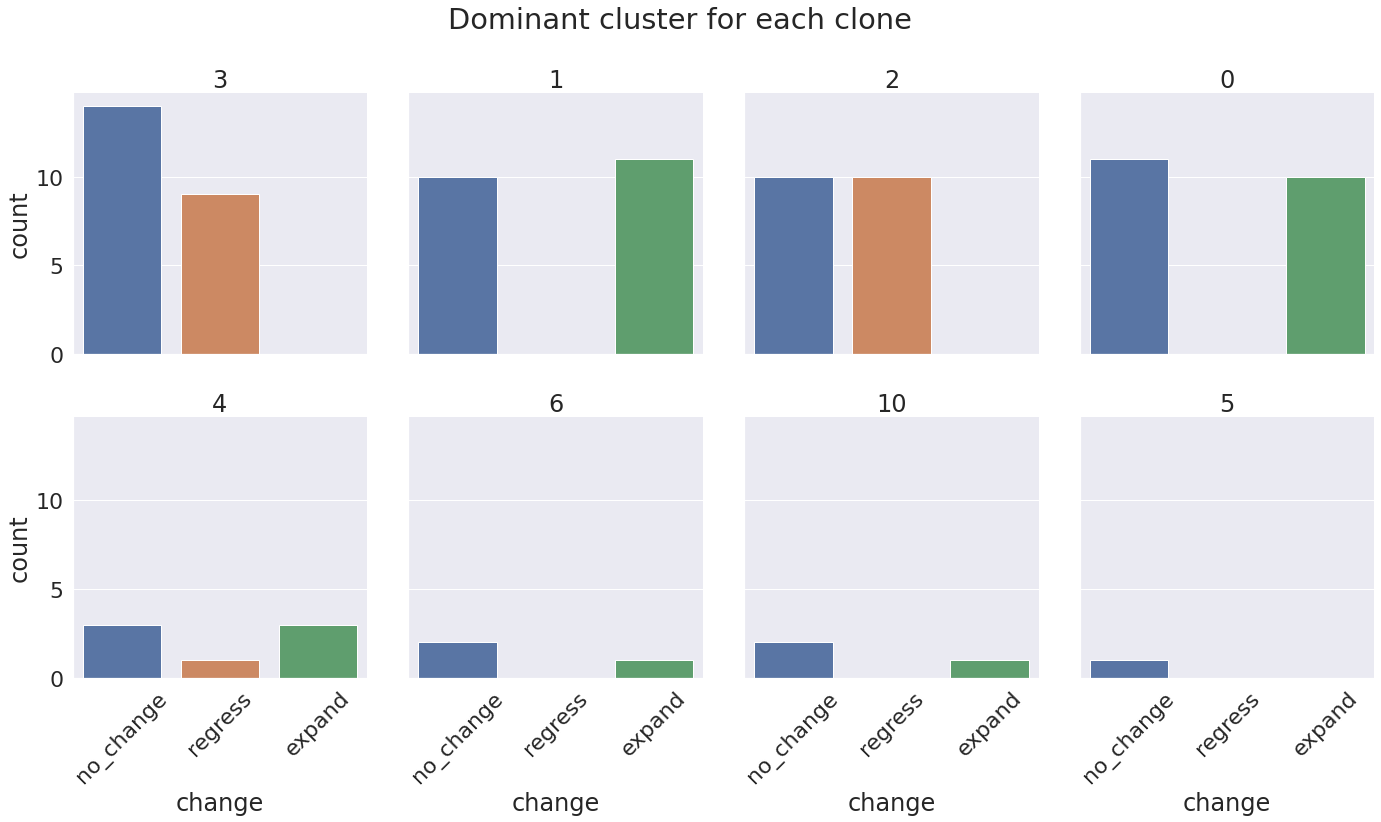

In [5]:
dom_df = pd.read_csv(join(dom_indir, "combinedConditions_dominant_cluster.csv"), index_col=0)
#dom_df
enrichment_df = pd.read_csv(clone_change_f, index_col=0)
#enrichment_df
merge_df = pd.merge(dom_df, enrichment_df, left_index=True, right_index=True)
merge_df

df = merge_df["dominant_cluster"].apply(lambda x: x.split(";"))
df

new_merge_df = pd.DataFrame(columns=["dominant_cluster", "change"])
for nm, clusts in df.iteritems():
    for cl in clusts:
        new_merge_df = new_merge_df.append(pd.Series({"dominant_cluster":cl, "change": merge_df.loc[nm, "change"],
                                      }, name=nm))
new_merge_df            

sns.set(font_scale = 2)
g = sns.catplot(data=new_merge_df, col="dominant_cluster", col_wrap=4, sharex=True, sharey=True,
                x="change",
                kind="count", order=["no_change", "regress", "expand"])

for axes in g.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
#g.fig.subplots_adjust(wspace=.8)

g.set_titles(col_template = '{col_name}')

g.fig.suptitle("Dominant cluster for each clone", y=1.05)
plt.savefig(join(outdir, "dominant_cluster_sig_counts.png"), bbox_inches='tight')

merge_df.to_csv(join(outdir, "clones_meta.csv"))

## Do the same, but use the Input dominant clone and then plot

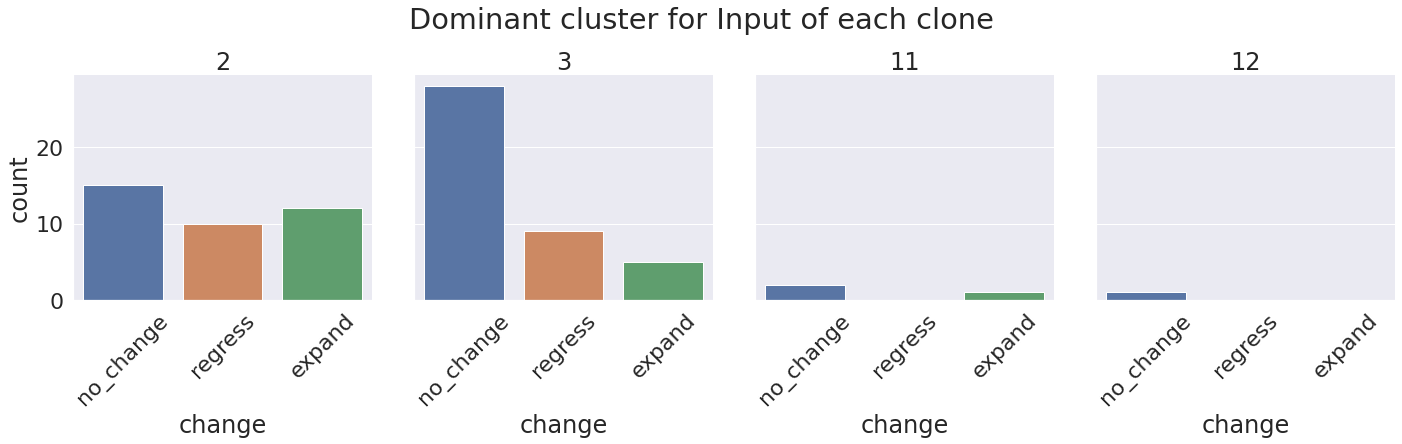

In [6]:
if input_id is not None and input_id != "None":  
    dom_df = pd.read_csv(join(dom_indir, "dominant_cluster.csv"), index_col=0)
    dom_df
    dom_df["name"] = dom_df["donor"].astype(str) + "_" + dom_df["clone"].astype(str)
    dom_df["condition"] = [x.split("_")[-1] for x in dom_df.index]
    in_df = dom_df[dom_df["condition"]==input_id].set_index("name", drop=False)
    in_df
    merge_df = pd.merge(in_df, enrichment_df, left_index=True, right_index=True)
    merge_df

    df = merge_df["dominant_cluster"].apply(lambda x: x.split(";"))
    #df

    new_merge_df = pd.DataFrame(columns=["in_dominant_cluster", "change", "in_size"])
    for nm, clusts in df.iteritems():
        for cl in clusts:
            new_merge_df = new_merge_df.append(pd.Series({"in_dominant_cluster":cl, "change": merge_df.loc[nm, "change"],
                                          "in_size": merge_df.loc[nm, "# Input Cells in Cluster"]}, name=nm))
    #new_merge_df            

    sns.set(font_scale = 2)
    g = sns.catplot(data=new_merge_df, col="in_dominant_cluster", col_wrap=4, sharex=True, sharey=True,
                    x="change",
                    kind="count", order=["no_change", "regress", "expand"])

    for axes in g.axes.flat:
        axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    #g.fig.subplots_adjust(wspace=.8)

    g.set_titles(col_template = '{col_name}')

    g.fig.suptitle("Dominant cluster for Input of each clone", y=1.05)
    plt.savefig(join(outdir, "input_dominant_cluster_sig_counts.png"), bbox_inches='tight')

    merge_df.to_csv(join(outdir, "inputDominant_clones_meta.csv"))
    

    print(f"Number of clones with multiple dominant clusters {new_merge_df.index.duplicated().sum()}")

    g = sns.catplot(data=new_merge_df.astype({"in_size": int}), col="in_dominant_cluster", col_wrap=4, sharex=True, sharey=True,
                    x="change", y="in_size", 
                    kind="swarm", order=["no_change", "regress", "expand"])
    plt.savefig(join(outdir, "input_dominant_cluster_sig_and_size.png"), bbox_inches='tight')


    g = sns.catplot(data=new_merge_df.loc[~(new_merge_df.index.duplicated(keep=False))].astype({"in_size": int}), col="in_dominant_cluster", col_wrap=4, sharex=True, sharey=True,
                    x="change", y="in_size", 
                    kind="swarm", order=["no_change", "regress", "expand"])
    print(f"Number of clones with multiple dominant clusters {new_merge_df.index.duplicated().sum()}")
    g.fig.suptitle(f"Removing clones with tied top clusters ({new_merge_df.index.duplicated(keep=False).sum()} total)")

    plt.savefig(join(outdir, "input_dominant_cluster_removeSize_sig_and_size.png"), bbox_inches='tight')
